In [1]:
import os
import cv2
import skimage
import coco.coco as coco

import numpy as np
import matplotlib.pyplot as plt

from mrcnn import visualize
import mrcnn.model as modellib

In [2]:
ROOT_DIR = os.path.abspath('../')
MODEL_DIR = os.path.join(ROOT_DIR, 'logs/')

COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'Segmentation\model\mask_rcnn_coco.h5')

In [3]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [4]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [5]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [6]:
image = skimage.io.imread('assets/Mayan.jpg')

# Run detection
results = model.detect([image], verbose=1)
r = results[0]

print(image.shape, np.shape(r['masks']))

Processing 1 images
image                    shape: (2340, 1080, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 2340.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
(2340, 1080, 3) (2340, 1080, 10)


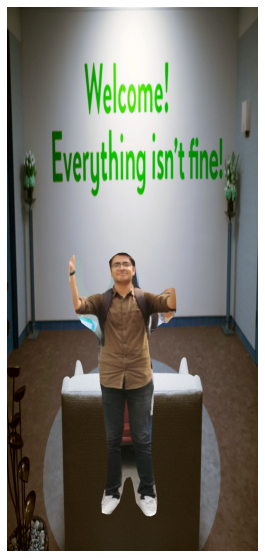

In [7]:
# bg_image = skimage.io.imread('assets/bg_image.png')
bg_image = cv2.imread('assets/bg_image.png')
bg_image = skimage.transform.resize(bg_image, np.shape(image))

mask = r['masks'][:, :, 0]

mask_image = image.copy()
for c in range(3):
        mask_image[:, :, c] = np.where(mask == 1,
                                    image[:, :, c],
                                    bg_image[:, :, c] * 255)


plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(mask_image)

In [8]:
cap = cv2.VideoCapture('assets/video.mp4')
frame_width = int(cap.get(3)) 
frame_height = int(cap.get(4)) 
size = (frame_width, frame_height)

writer = cv2.VideoWriter('masked_vid.avi',  
                         cv2.VideoWriter_fourcc(*'MJPG'), 
                         10, size)
bg_image = cv2.cvtColor(bg_image.astype('uint8'), cv2.COLOR_BGR2RGB)
bg_image = skimage.transform.resize(bg_image, (size[1], size[0]))


while(True):
    ret, frame = cap.read()

    results = model.detect([frame], verbose=1)
    r = results[0]
    
#     person_index = np.where(r['class_ids'] == 1)
    mask = r['masks'][:, :, 0]
    mask_frame = frame.copy()
    
#     print(person_index)
    
    for c in range(3):
            mask_frame[:, :, c] = np.where(mask == 1,
                                        frame[:, :, c],
                                        bg_image[:, :, c] * 255)

    writer.write(mask_frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1

KeyboardInterrupt: 